In [1]:
import kagglehub
import pandas as pd
import os
import numpy as np
from pathlib import Path
from pyspark.sql import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_importance
import shap



sns.set(style="white")


c:\Users\korph\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_DIR = Path.cwd()
data_file = BASE_DIR / "DataBase" / "Cleaned_data.csv"

df = pd.read_csv(data_file)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


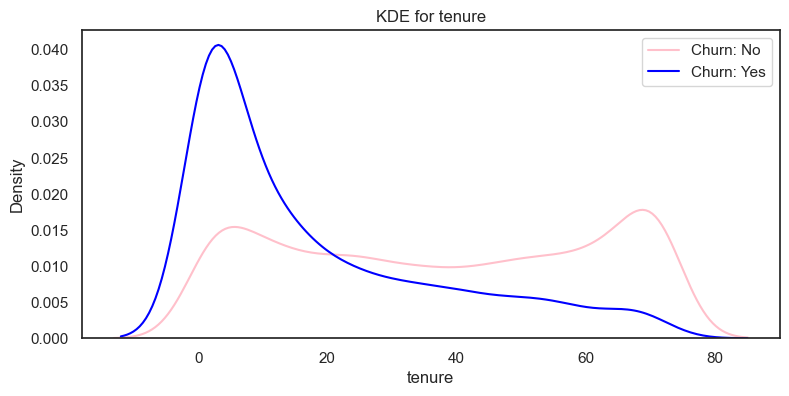

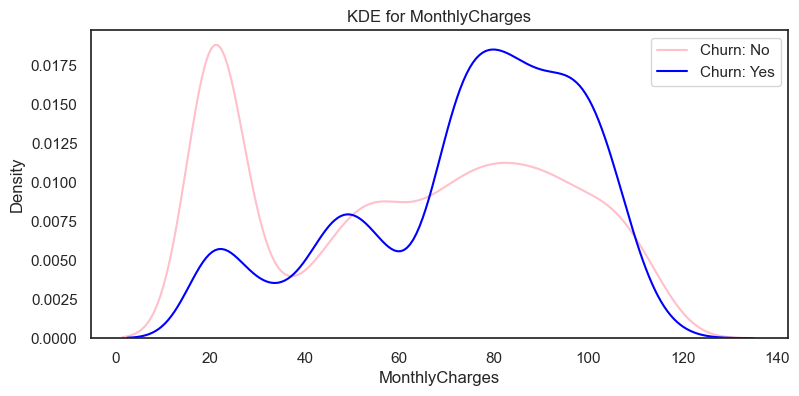

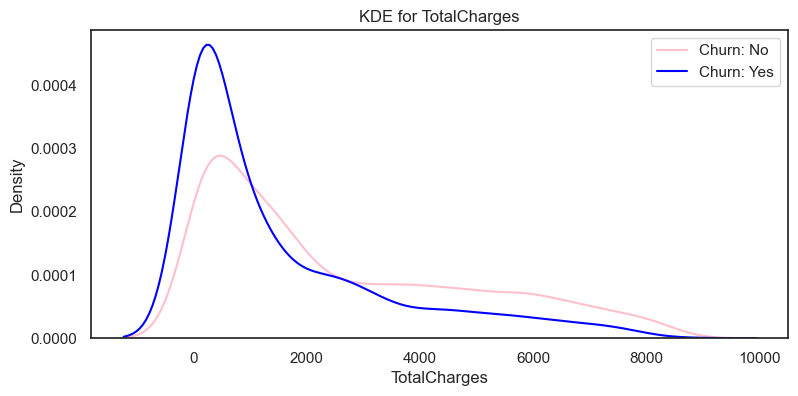

In [3]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Churn'] == 'No'][feature].dropna(), color= 'pink', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == 'Yes'][feature].dropna(), color= 'blue', label= 'Churn: Yes')
    plt.legend()
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

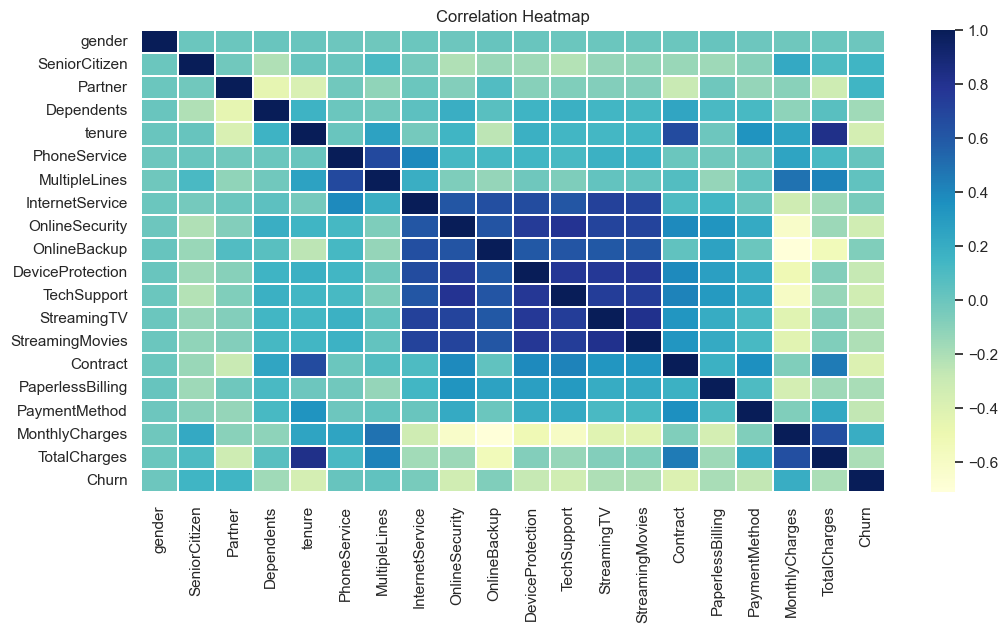

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cor_df = df.drop(['customerID'], axis=1)

cor_df = cor_df.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x)

corr = cor_df.corr()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=0.2, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()


In [5]:
encoders = {}

for col in df.columns:
    if df[col].dtype == "object":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le


In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


In [7]:
X = df.drop(columns=['customerID', 'Churn']) 
y = df["Churn"]                

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

In [8]:
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.7962371317003905, test set 0.8105039034776437


c:\Users\korph\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
print(f"XGBoost : training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

XGBoost : training set acc: 0.8182463613773517, test set 0.8126330731014905


c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:11:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


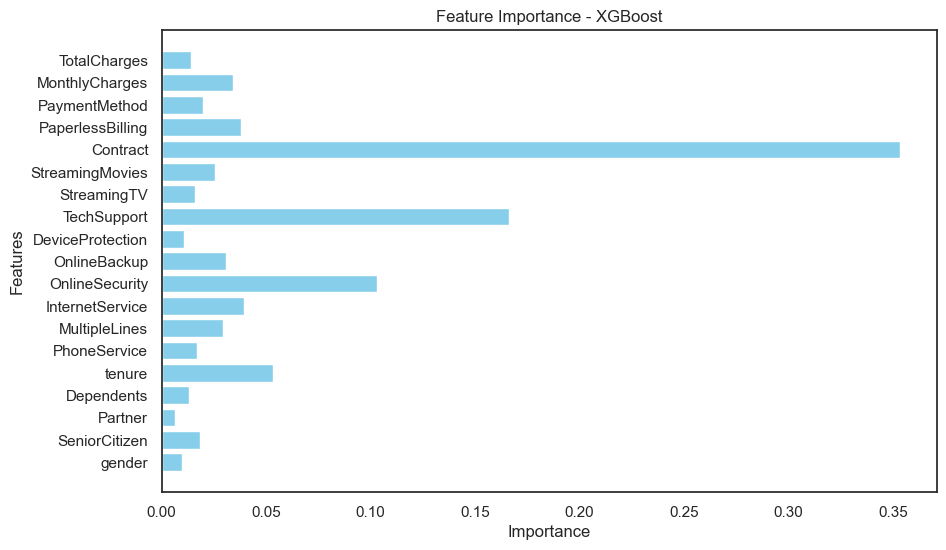

In [ ]:
importance = model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importance, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost")
plt.show()


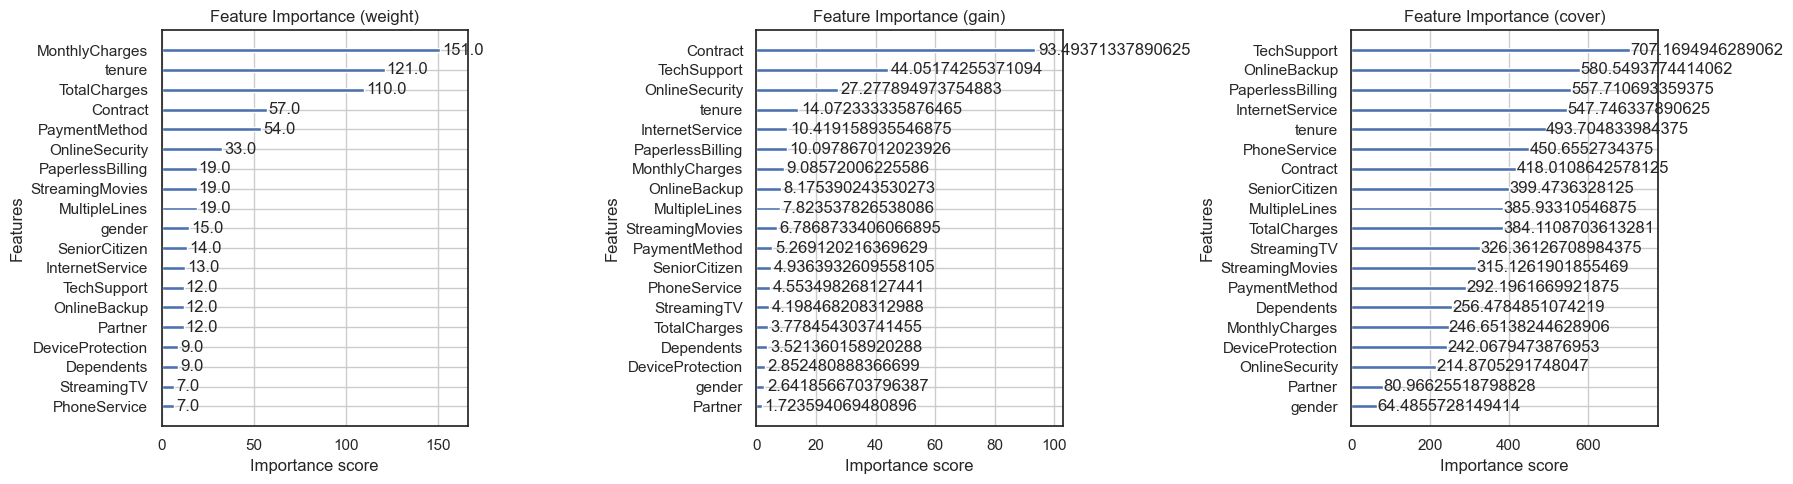

In [ ]:
importance_types = ['weight', 'gain', 'cover']

plt.figure(figsize=(18, 5))

for i, imp_type in enumerate(importance_types, 1):
    plt.subplot(1, 3, i)
    plot_importance(model, importance_type=imp_type, ax=plt.gca(), title=f"Feature Importance ({imp_type})")
    
plt.tight_layout()
plt.show()


In [ ]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train)


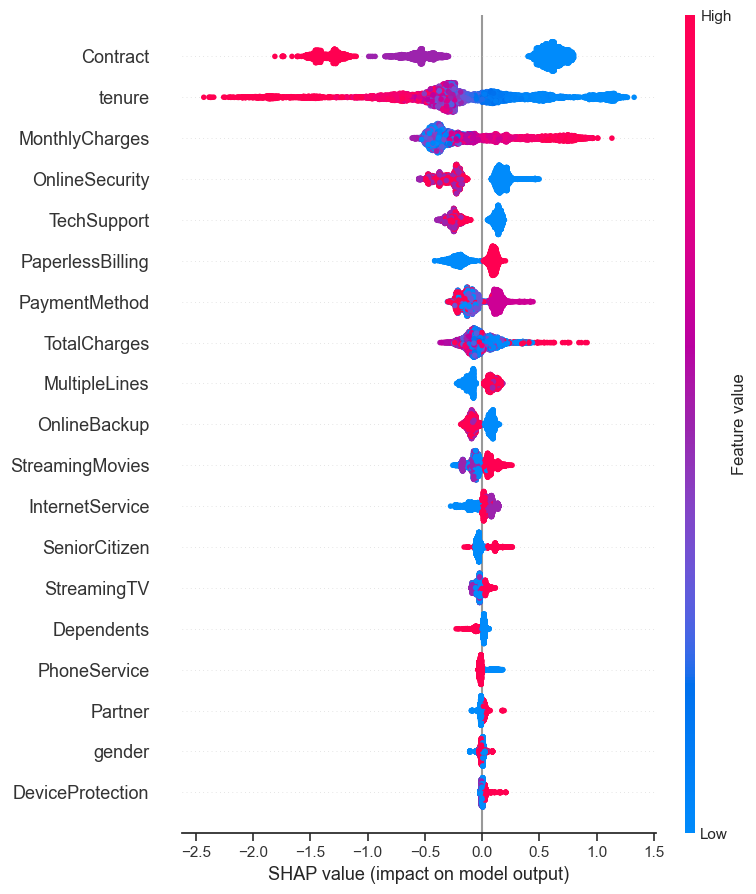

In [ ]:
shap.summary_plot(shap_values, X_train)
